[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Anything Model (SAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643)

Segment Anything Model (SAM): a new AI model from Meta AI that can "cut out" any object, in any image, with a single click. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training. This notebook is an extension of the [official notebook](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb) prepared by Meta AI.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-paper.png)

## Complementary Materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-segment-anything-model-sam)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model.

![segment anything model blogpost](https://media.roboflow.com/notebooks/examples/segment-anything-model-blogpost.png)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- Install Segment Anything Model (SAM)
- Download Example Data
- Load Model
- Automated Mask Generation
- Generate Segmentation with Bounding Box
- Segment Anything in Roboflow Universe Dataset

## Let's begin!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [12]:
!nvidia-smi

Mon Nov  4 15:55:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [13]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [14]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [15]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

### Download SAM weights

In [16]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [17]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [18]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

## Load Model

In [19]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [20]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [91]:
SamAutomaticMaskGenerator.__init__(model)

NameError: name 'model' is not defined

In [165]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=7,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    min_mask_region_area=100000

)

In [22]:
import os

IMAGE_NAME = "/content/data/arac2.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [166]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [76]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

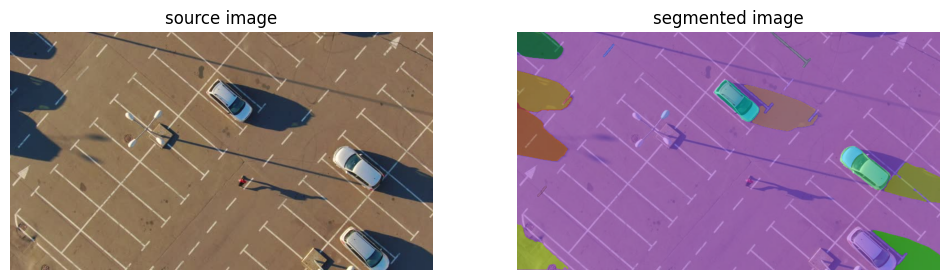

In [167]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

In [95]:
import numpy as np

# Örneğin, masks ve manual_masks el ile ve otomatik oluşturulan maskeleri temsil eder
# masks: SAM tarafından üretilen otomatik maskeler
# manual_masks: El ile oluşturulmuş maskeler
# Her iki liste de aynı uzunlukta ve maskeler ikili (0 ve 1) olmalı

def calculate_iou(mask1, mask2):
    """ IoU (Intersection over Union) hesaplamak için bir yardımcı fonksiyon """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

def calculate_dice(mask1, mask2):
    """ Dice katsayısı hesaplamak için bir yardımcı fonksiyon """
    intersection = np.logical_and(mask1, mask2).sum()
    return (2.0 * intersection) / (mask1.sum() + mask2.sum()) if (mask1.sum() + mask2.sum()) != 0 else 0

# Benzerlik sonuçlarını tutmak için listeler
iou_scores = []
dice_scores = []

# İki maske setini karşılaştırarak benzerlik skorlarını hesaplayın
for auto_mask, manual_mask in zip(masks, masks1):
    iou = calculate_iou(auto_mask, manual_mask)
    dice = calculate_dice(auto_mask, manual_mask)
    iou_scores.append(iou)
    dice_scores.append(dice)
    print(f"IoU: {iou:.4f}, Dice: {dice:.4f}")

# Ortalama benzerlik skorlarını hesaplayın
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"Ortalama IoU: {mean_iou:.4f}, Ortalama Dice: {mean_dice:.4f}")


IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
Ortalama IoU: 0.0000, Ortalama Dice: 0.0000


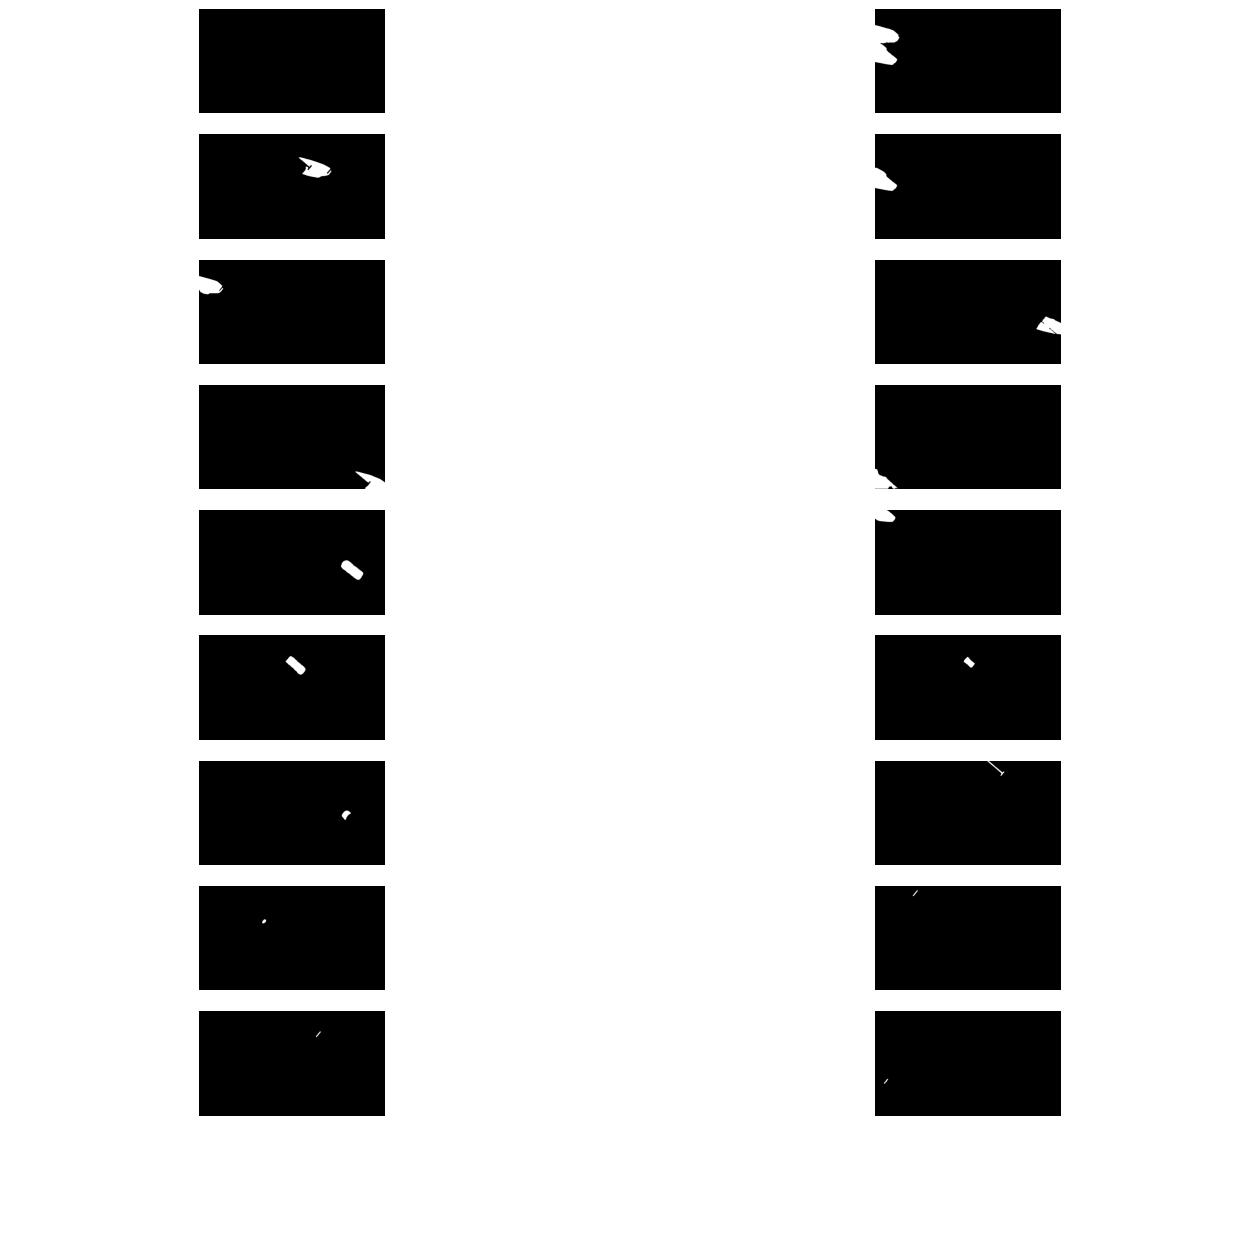

In [168]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

import math

# masks listesindeki görüntü sayısını hesaplayın
num_images = len(masks)

# Satır sayısını sabit tutarak dinamik sütun sayısı hesaplayın
rows = 10
cols = math.ceil(num_images / rows)

# Grid boyutunu otomatik ayarlayarak görüntüleri çizdirin
sv.plot_images_grid(
    images=masks,
    grid_size=(rows, cols),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [169]:
mask_predictor = SamPredictor(sam)

In [170]:
import os

IMAGE_NAME = "/content/data/arac2.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [171]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [172]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [100]:
widget.bboxes

[{'x': 341, 'y': 69, 'width': 101, 'height': 102, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [173]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [174]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks1, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

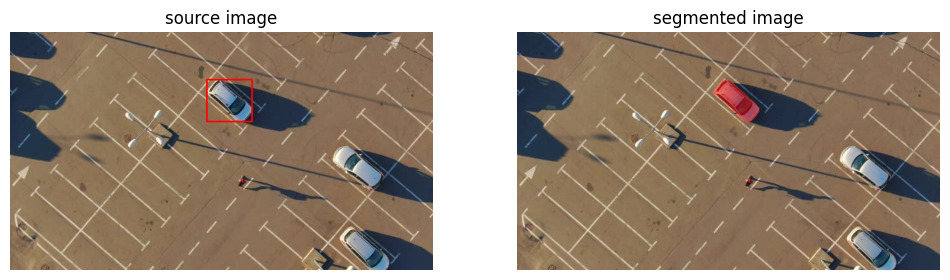

In [175]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks1),
    mask=masks1
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

In [44]:
mask_annotator

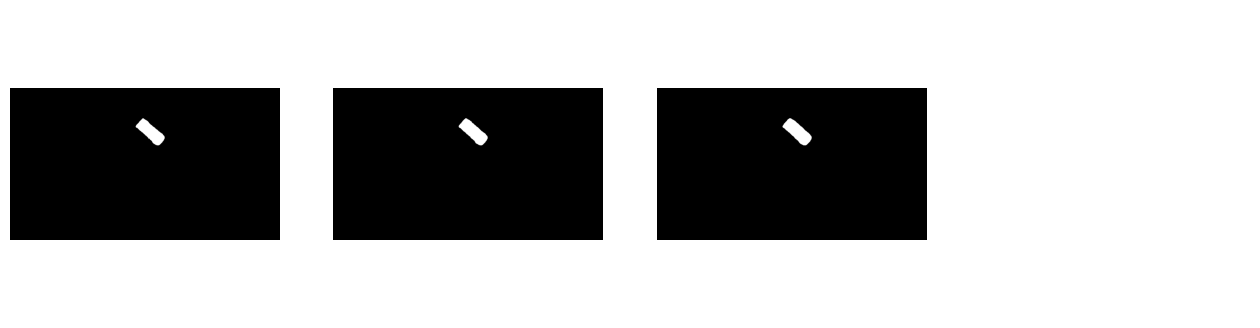

In [176]:
import supervision as v

sv.plot_images_grid(
    images=masks1,
    grid_size=(1, 4),
    size=(16, 4)
)

In [177]:
masks2= masks1[0]

In [58]:
import numpy as np

# IoU Hesaplama Fonksiyonu
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

# Dice Katsayısı Hesaplama Fonksiyonu
def calculate_dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    return (2.0 * intersection) / (mask1.sum() + mask2.sum()) if (mask1.sum() + mask2.sum()) != 0 else 0


In [109]:
import numpy as np

# IoU Hesaplama Fonksiyonu
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0

# Dice Katsayısı Hesaplama Fonksiyonu
def calculate_dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    return (2.0 * intersection) / (mask1.sum() + mask2.sum()) if (mask1.sum() + mask2.sum()) != 0 else 0

# Örneğin, masks ve masks1 listelerindeki maske sayılarının aynı olduğunu varsayıyoruz
iou_scores = []
dice_scores = []

# Her maske çifti için benzerlik hesaplama
for sam_mask, manual_mask in zip(masks, masks2):
    iou = calculate_iou(sam_mask, manual_mask)
    dice = calculate_dice(sam_mask, manual_mask)
    iou_scores.append(iou)
    dice_scores.append(dice)
    print(f"IoU: {iou:.4f}, Dice: {dice:.4f}")

# Ortalama benzerlik skorlarını hesaplayın
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"Ortalama IoU: {mean_iou:.4f}")
print(f"Ortalama Dice: {mean_dice:.4f}")


IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
IoU: 0.0000, Dice: 0.0000
Ortalama IoU: 0.0000
Ortalama Dice: 0.0000


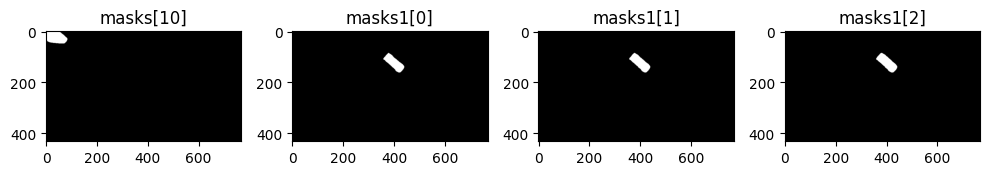

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(masks[10], cmap='gray')
plt.title("masks[10]")

plt.subplot(1, 4, 2)
plt.imshow(masks1[0], cmap='gray')
plt.title("masks1[0]")

plt.subplot(1, 4, 3)
plt.imshow(masks1[1], cmap='gray')
plt.title("masks1[1]")

plt.subplot(1, 4, 4)
plt.imshow(masks1[2], cmap='gray')
plt.title("masks1[2]")

plt.tight_layout()
plt.show()

In [112]:
import numpy as np

def jaccard_similarity(image1, image2):
    intersection = np.logical_and(image1, image2).sum()
    union = np.logical_or(image1, image2).sum()
    return intersection / union if union != 0 else 1.0

# Eşik değeri
threshold = 0.7  # %70 benzerlik

# masks1'in yalnızca ilk görselini masks içindeki görsellerle karşılaştırma
image2 = masks1[0]
similarities = [jaccard_similarity(image1, image2) for image1 in masks]
most_similar_index = np.argmax(similarities)
max_similarity = similarities[most_similar_index]

if max_similarity >= threshold:
    print(f"masks1 içindeki ilk görsele en benzer masks içindeki görselin indeksi: {most_similar_index}, Benzerlik: {max_similarity}")
else:
    print("Belirlenen eşik değerin üzerinde benzer bir görsel bulunamadı.")


masks1 içindeki ilk görsele en benzer masks içindeki görselin indeksi: 12, Benzerlik: 0.9627906976744186


In [113]:
def dice_similarity(image1, image2):
    intersection = np.logical_and(image1, image2).sum()
    return (2 * intersection) / (image1.sum() + image2.sum()) if (image1.sum() + image2.sum()) != 0 else 1.0
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_flat(image1, image2):
    image1_flat = image1.flatten().astype(int)
    image2_flat = image2.flatten().astype(int)
    return cosine_similarity([image1_flat], [image2_flat])[0][0]
def mse(image1, image2):
    return np.mean((image1.astype(int) - image2.astype(int)) ** 2)


In [117]:
import numpy as np

# IoU (Intersection over Union) fonksiyonu
def iou_score(image1, image2):
    intersection = np.logical_and(image1, image2).sum()
    union = np.logical_or(image1, image2).sum()
    return intersection / union if union != 0 else 1.0

# Dice Similarity Coefficient (F1-score) fonksiyonu
def dice_similarity(image1, image2):
    intersection = np.logical_and(image1, image2).sum()
    return (2 * intersection) / (image1.sum() + image2.sum()) if (image1.sum() + image2.sum()) != 0 else 1.0

# Cosine Similarity fonksiyonu
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_flat(image1, image2):
    image1_flat = image1.flatten().astype(int)
    image2_flat = image2.flatten().astype(int)
    return cosine_similarity([image1_flat], [image2_flat])[0][0]

# Mean Squared Error (MSE) fonksiyonu
def mse(image1, image2):
    return np.mean((image1.astype(int) - image2.astype(int)) ** 2)

# Eşik değerleri belirleyin
iou_threshold = 0.7
dice_threshold = 0.7
cosine_threshold = 0.7
mse_threshold = 1000  # Küçük olması daha iyi, bunu optimize edin

# masks1'in yalnızca ilk görselini alalım
image2 = masks1[0]

# Her metrik için benzerlik değerlerini saklayın
iou_similarities = [iou_score(image1, image2) for image1 in masks]
dice_similarities = [dice_similarity(image1, image2) for image1 in masks]
cosine_similarities = [cosine_similarity_flat(image1, image2) for image1 in masks]
mse_values = [mse(image1, image2) for image1 in masks]

# En benzer görüntülerin indekslerini bulma
most_similar_iou = np.argmax(iou_similarities)
most_similar_dice = np.argmax(dice_similarities)
most_similar_cosine = np.argmax(cosine_similarities)
least_mse = np.argmin(mse_values)

# Eşik değerlere göre sonuçları yazdırın
print(f"IoU en benzer (indeks: {most_similar_iou}): {iou_similarities[most_similar_iou]}")
print(f"Dice en benzer (indeks: {most_similar_dice}): {dice_similarities[most_similar_dice]}")
print(f"Cosine en benzer (indeks: {most_similar_cosine}): {cosine_similarities[most_similar_cosine]}")
print(f"MSE en düşük (indeks: {least_mse}): {mse_values[least_mse]}")

# Eşikleri karşılayıp karşılamadığını kontrol etme
if iou_similarities[most_similar_iou] >= iou_threshold:
    print(f"IoU ile benzerlik eşiğini karşılayan görsel: {most_similar_iou}")

if dice_similarities[most_similar_dice] >= dice_threshold:
    print(f"Dice ile benzerlik eşiğini karşılayan görsel: {most_similar_dice}")

if cosine_similarities[most_similar_cosine] >= cosine_threshold:
    print(f"Cosine ile benzerlik eşiğini karşılayan görsel: {most_similar_cosine}")

if mse_values[least_mse] <= mse_threshold:
    print(f"MSE ile benzerlik eşiğini karşılayan görsel: {least_mse}")


IoU en benzer (indeks: 12): 0.9627906976744186
Dice en benzer (indeks: 12): 0.981042654028436
Cosine en benzer (indeks: 12): 0.9811776493464633
MSE en düşük (indeks: 12): 0.00033757716049382714
IoU ile benzerlik eşiğini karşılayan görsel: 12
Dice ile benzerlik eşiğini karşılayan görsel: 12
Cosine ile benzerlik eşiğini karşılayan görsel: 12
MSE ile benzerlik eşiğini karşılayan görsel: 12


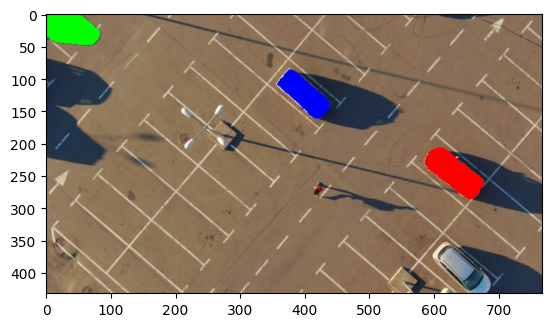

In [194]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image # PIL kütüphanesini eklemeyi unutmayın


# Orijinal resmi yükle
image = Image.open("/content/data/arac2.jpg") # Dosya adını kendi resminizle değiştirin
image = np.array(image)


def show_masks_on_image(image, masks):
    """
    Maskeleri orijinal görüntü üzerinde renkli olarak gösterir.

    Args:
        image: Orijinal görüntü (NumPy dizisi).
        masks: Maske listesi (her maske bir NumPy dizisi).
    """

    # Maskeli görüntüyü saklamak için bir kopya oluştur
    masked_image = image.copy()

    # Renkler için bir liste oluşturun
    colors = [[255,0,0],[0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255]] # Kırmızı, yeşil, mavi, sarı, magenta


    for i, mask in enumerate(masks):
        # Maskeyi 0 ve 1'lerden oluşan sayısal formata dönüştür
        mask = mask.astype(int)

        # Renk maskesi oluştur
        color_mask = np.zeros_like(image)
        color = colors[i % len(colors)] # Renk listesini döngüye alın
        for j in range(3):  # RGB kanalları için döngü
            color_mask[:,:,j] = mask * color[j]

        # Maskeyi görüntüyle birleştir
        masked_image = np.where(mask[:,:,np.newaxis], color_mask, masked_image)


    # Sonucu göster
    plt.imshow(masked_image)
    plt.show()

# masks1 listesinin ilk 5 maskesini orijinal görüntü üzerinde göster
show_masks_on_image(image, masks[8:11])

In [132]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# IoU (Intersection over Union) fonksiyonu
def iou_score(image1, image2):
    intersection = np.logical_and(image1, image2).sum()
    union = np.logical_or(image1, image2).sum()
    return intersection / union if union != 0 else 1.0

# Dice Similarity Coefficient (F1-score) fonksiyonu
def dice_similarity(image1, image2):
    intersection = np.logical_and(image1, image2).sum()
    return (2 * intersection) / (image1.sum() + image2.sum()) if (image1.sum() + image2.sum()) != 0 else 1.0

# Cosine Similarity fonksiyonu
def cosine_similarity_flat(image1, image2):
    image1_flat = image1.flatten().astype(int)
    image2_flat = image2.flatten().astype(int)
    return cosine_similarity([image1_flat], [image2_flat])[0][0]

# Mean Squared Error (MSE) fonksiyonu
def mse(image1, image2):
    return np.mean((image1.astype(int) - image2.astype(int)) ** 2)

# Eşik değerleri belirleyin
iou_threshold = 0.1
dice_threshold = 0.1
cosine_threshold = 0.1
mse_threshold = 0.01  # Küçük olması daha iyi, bunu optimize edin

# masks1'in yalnızca ilk görselini alalım
image2 = masks1[0]

# Her metrik için benzerlik değerlerini saklayın
iou_similarities = [iou_score(image1, image2) for image1 in masks]
dice_similarities = [dice_similarity(image1, image2) for image1 in masks]
cosine_similarities = [cosine_similarity_flat(image1, image2) for image1 in masks]
mse_values = [mse(image1, image2) for image1 in masks]

# Eşik değerlere göre benzer maskeleri bulma
similar_iou_indices = [i for i, sim in enumerate(iou_similarities) if sim >= iou_threshold]
similar_dice_indices = [i for i, sim in enumerate(dice_similarities) if sim >= dice_threshold]
similar_cosine_indices = [i for i, sim in enumerate(cosine_similarities) if sim >= cosine_threshold]
similar_mse_indices = [i for i, mse_val in enumerate(mse_values) if mse_val <= mse_threshold]

# Sonuçları yazdırma
print("IoU eşiğini karşılayan maskeler ve benzerlik değerleri:")
for idx in similar_iou_indices:
    print(f"Indeks: {idx}, IoU: {iou_similarities[idx]}")

print("\nDice eşiğini karşılayan maskeler ve benzerlik değerleri:")
for idx in similar_dice_indices:
    print(f"Indeks: {idx}, Dice: {dice_similarities[idx]}")

print("\nCosine eşiğini karşılayan maskeler ve benzerlik değerleri:")
for idx in similar_cosine_indices:
    print(f"Indeks: {idx}, Cosine: {cosine_similarities[idx]}")

print("\nMSE eşiğini karşılayan maskeler ve değerleri:")
for idx in similar_mse_indices:
    print(f"Indeks: {idx}, MSE: {mse_values[idx]}")


IoU eşiğini karşılayan maskeler ve benzerlik değerleri:
Indeks: 12, IoU: 0.9627906976744186
Indeks: 14, IoU: 0.20791738382099828

Dice eşiğini karşılayan maskeler ve benzerlik değerleri:
Indeks: 12, Dice: 0.981042654028436
Indeks: 14, Dice: 0.34425762325448844

Cosine eşiğini karşılayan maskeler ve benzerlik değerleri:
Indeks: 12, Cosine: 0.9811776493464633
Indeks: 14, Cosine: 0.45597958706612973

MSE eşiğini karşılayan maskeler ve değerleri:
Indeks: 12, MSE: 0.00033757716049382714
Indeks: 14, MSE: 0.006935402199074074
Indeks: 17, MSE: 0.009979624807098766
Indeks: 18, MSE: 0.009862075617283951
Indeks: 19, MSE: 0.009491343557098766


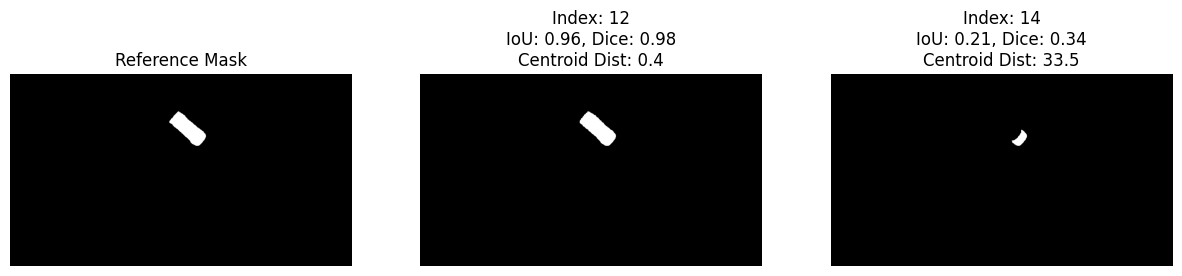

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# IoU ve Dice fonksiyonlarının burada tanımlı olduğunu varsayalım.
# IoU (Intersection over Union) fonksiyonu
def iou(image1, image2):
    intersection = np.logical_and(image1, image2).sum()
    union = np.logical_or(image1, image2).sum()
    return intersection / union if union != 0 else 1.0

# Dice Similarity Coefficient (F1-score) fonksiyonu
def dice_similarity(image1, image2):
    intersection = np.logical_and(image1, image2).sum()
    return (2 * intersection) / (image1.sum() + image2.sum()) if (image1.sum() + image2.sum()) != 0 else 1.0

def centroid(mask):
    """ Maskenin kütle merkezi """
    coords = np.argwhere(mask)
    return coords.mean(axis=0) if coords.size else None

def distance_between_centroids(mask1, mask2):
    """ İki maske arasındaki kütle merkezi mesafesini hesaplar """
    c1, c2 = centroid(mask1), centroid(mask2)
    if c1 is not None and c2 is not None:
        return euclidean(c1, c2)
    return float('inf')

# İlgili eşik değerleri
iou_threshold = 0.1
dice_threshold = 0.1
centroid_distance_threshold = 1  # piksel cinsinden merkez mesafesi eşiği

# masks1'deki ilk görseli baz olarak alalım
reference_mask = masks1[0]

# Benzer maskeleri bulma
matching_masks = []
for i, mask in enumerate(masks):
    iou_score = iou(mask, reference_mask)  # Fonksiyonu çağırarak sonucu alın
    dice_score = dice_similarity(mask, reference_mask)  # Fonksiyonu çağırarak sonucu alın
    centroid_distance = distance_between_centroids(mask, reference_mask)

    # Eşiklere göre filtreleme
    if iou_score >= iou_threshold or dice_score >= dice_threshold or centroid_distance < centroid_distance_threshold:
        matching_masks.append((i, mask, iou_score, dice_score, centroid_distance))

# Sonuçları görselleştirme
fig, axes = plt.subplots(1, len(matching_masks) + 1, figsize=(15, 5))

# Referans maskeyi ilk pozisyona koy
axes[0].imshow(reference_mask, cmap='gray')
axes[0].set_title("Reference Mask")
axes[0].axis('off')

# Eşik değerlerini karşılayan maskeleri yanına ekleyelim
for j, (idx, mask, iou_score, dice_score, centroid_distance) in enumerate(matching_masks):
    axes[j + 1].imshow(mask, cmap='gray')
    axes[j + 1].set_title(f"Index: {idx}\nIoU: {iou_score:.2f}, Dice: {dice_score:.2f}\nCentroid Dist: {centroid_distance:.1f}")
    axes[j + 1].axis('off')

plt.show()


In [182]:
def calculate_area(mask):
    return np.sum(mask)  # True piksellerin toplamı, maskenin alanı

reference_area = calculate_area(reference_mask)
area_similarities = []

for i, mask in enumerate(masks):
    mask_area = calculate_area(mask)
    area_ratio = mask_area / reference_area if reference_area != 0 else 0
    area_similarities.append((i, area_ratio))

# Eşiğe göre benzer alanları seçelim
area_threshold = 0.65  # Eşik değeri, isteğe göre ayarlayın
matching_areas = [index for index, ratio in area_similarities if area_threshold <= ratio <= 1 / area_threshold]

print("Benzer alanlara sahip maskeler:")
for index in matching_areas:
    print(f"Mask İndeksi: {index}, Alan Oranı: {area_similarities[index][1]}")


Benzer alanlara sahip maskeler:
Mask İndeksi: 6, Alan Oranı: 1.4602409638554217
Mask İndeksi: 7, Alan Oranı: 1.2925989672977625
Mask İndeksi: 8, Alan Oranı: 1.2895008605851979
Mask İndeksi: 9, Alan Oranı: 1.1607573149741826
Mask İndeksi: 10, Alan Oranı: 1.0096385542168675


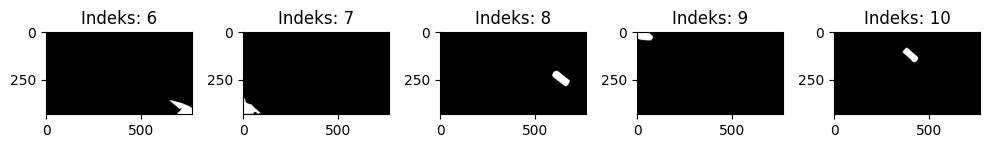

In [183]:
import matplotlib.pyplot as plt

# İlgili indeksleri belirtin
indices = [6,7,8,9,10]  # Örnek olarak

plt.figure(figsize=(10, 5))

for i, index in enumerate(indices):
    plt.subplot(1, len(indices), i+1)
    plt.imshow(masks[index], cmap='gray')
    plt.title(f"Indeks: {index}")

plt.tight_layout()
plt.show()

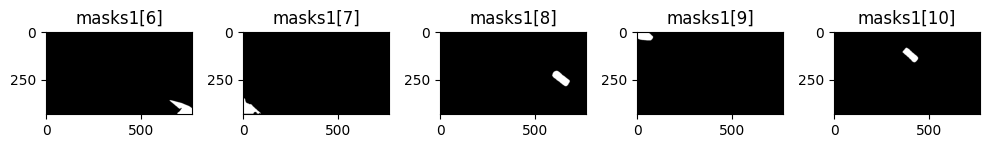

In [189]:
import matplotlib.pyplot as plt

# masks1 içindeki 6, 7, 8, 9, 10 indeksli maskeleri gösterir (eğer varsa)
plt.figure(figsize=(10, 5))

indices = [6, 7, 8, 9, 10]
num_indices = len(indices)

for i, index in enumerate(indices):
    if index < len(masks): # İndeksin liste boyutunu aşmadığından emin olun
        plt.subplot(1, num_indices, i + 1)
        plt.imshow(masks[index], cmap='gray')
        plt.title(f"masks1[{index}]")
    else:
      print(f"Uyarı: masks1 listesinde {index} indeksi yok.")


plt.tight_layout()
plt.show()

In [111]:
import numpy as np

def jaccard_similarity(image1, image2):
    intersection = np.logical_and(image1, image2).sum()
    union = np.logical_or(image1, image2).sum()
    return intersection / union if union != 0 else 1.0

# Eşik değeri
threshold = 0.7  # %70 benzerlik

# masks (96 görsel) ve masks1 (3 görsel) değişkenlerinizin tanımlı olduğunu varsayıyorum.
for i, image2 in enumerate(masks1):
    similarities = [jaccard_similarity(image1, image2) for image1 in masks]
    most_similar_index = np.argmax(similarities)
    max_similarity = similarities[most_similar_index]

    if max_similarity >= threshold:
        print(f"masks1 içindeki {i}. görsele en benzer masks içindeki görselin indeksi: {most_similar_index}, Benzerlik: {max_similarity}")
    else:
        print(f"masks1 içindeki {i}. görsel için belirlenen eşik değerin üzerinde benzer bir görsel bulunamadı.")


masks1 içindeki 0. görsele en benzer masks içindeki görselin indeksi: 12, Benzerlik: 0.9627906976744186
masks1 içindeki 1. görsele en benzer masks içindeki görselin indeksi: 12, Benzerlik: 0.9814998348199537
masks1 içindeki 2. görsele en benzer masks içindeki görselin indeksi: 12, Benzerlik: 0.9637355584082157


In [105]:
import numpy as np

def jaccard_similarity(image1, image2):
    intersection = np.logical_and(image1, image2).sum()
    union = np.logical_or(image1, image2).sum()
    return intersection / union if union != 0 else 1.0

# masks (96 görsel) ve masks1 (3 görsel) değişkenlerinizin tanımlı olduğunu varsayıyorum.

for image2 in masks1:
    similarities = [jaccard_similarity(image1, image2) for image1 in masks]
    most_similar_index = np.argmax(similarities)
    print(f"En benzer görselin indeksi (masks içinde): {most_similar_index}, Benzerlik: {similarities[most_similar_index]}")

En benzer görselin indeksi (masks içinde): 12, Benzerlik: 0.9627906976744186
En benzer görselin indeksi (masks içinde): 12, Benzerlik: 0.9814998348199537
En benzer görselin indeksi (masks içinde): 12, Benzerlik: 0.9637355584082157


In [64]:
masks

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [62]:
masks1

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

## Segment Anything in Roboflow Universe Dataset

### Utils Supporting Dataset Processing

A couple of helper functions that, unfortunately, we have to write ourselves to facilitate the processing of COCO annotations.

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

### Download Dataset from Roboflow

In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("hashira-fhxpj").project("mri-brain-tumor")
dataset = project.version(1).download("coco")

In [ ]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [ ]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [ ]:
CLASSES

['YES-TUMOR']

### Single Image Bounding Box to Mask

In [ ]:
# set random seed to allow easy reproduction of the experiment

import random
random.seed(10)

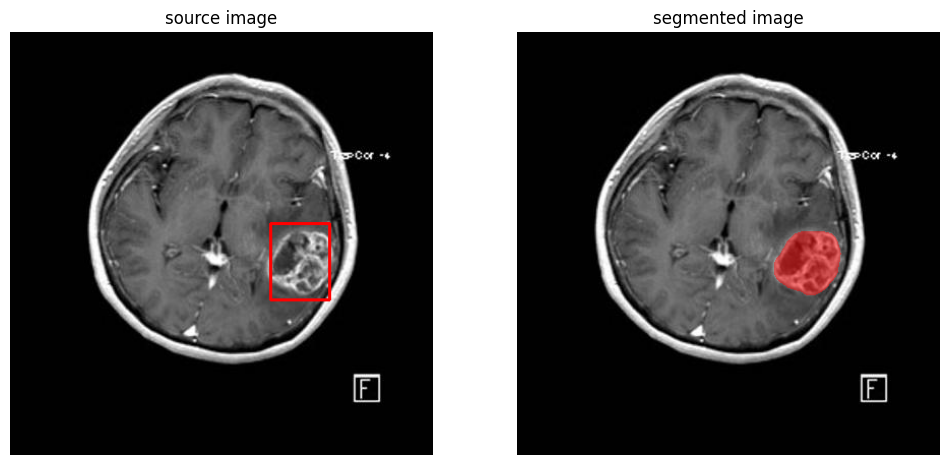

In [ ]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth)

# run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.